# Installation

In [1]:
!uv add langgraph langchain langsmith python-dotenv langchain_ollama langchain_community langchain_tavily

Resolved 138 packages in 7ms
Audited 133 packages in 0.30ms


In [2]:
## load env variables
from dotenv import load_dotenv

load_dotenv()

True

### Tavily Tool

In [3]:
## Create tavily tool
from langchain_tavily import TavilySearch

search_tool=TavilySearch(max_results=2)

### Custom Multiply Tool

In [4]:
## custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int if it is in string convert to int
        b (int): second int if it is in string convert to int

    Returns:
        int: result of the multiplication
    """
    return a * b

### Create LLM using Ollama

In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2", temperature=0)

In [6]:
## add tools in llm 
tools=[search_tool, multiply]
llm_with_tools=llm.bind_tools(tools)

### Creating the Chatbot

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

## State 
class State(TypedDict):
    messages:Annotated[list, add_messages]

## Node functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

## Compile the graph
graph = builder.compile()

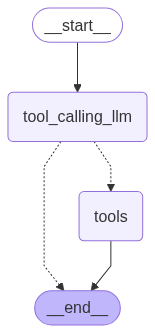

In [9]:
graph

### Using this Graph

In [ ]:
response=graph.invoke({"messages":"What is the recent AI news for today?"})

for m in response["messages"]:
    m.pretty_print()

In [10]:
response=graph.invoke({"messages":"What is 25 multiply by 5?"})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 25 multiply by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (15f95f44-3f67-4068-9c85-81e9507aad17)
 Call ID: 15f95f44-3f67-4068-9c85-81e9507aad17
  Args:
    a: 25
    b: 5
================================= Tool Message =================================
Name: multiply

125


In [ ]:
response=graph.invoke({"messages":"What is 10 multiply by 5 and then multiply by 2?"})

for m in response["messages"]:
    m.pretty_print()

### ReAct Agent 

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools", "tool_calling_llm")

## Compile the graph
graph = builder.compile()

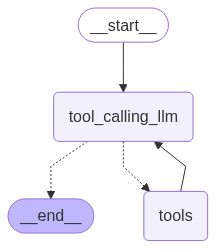

In [12]:
graph

In [13]:
response=graph.invoke({"messages":"Give me the recent AI news for today and then multiply 10 by 5?"})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news for today and then multiply 10 by 5?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (c529f61b-2224-44b6-b758-a67e86588328)
 Call ID: c529f61b-2224-44b6-b758-a67e86588328
  Args:
    query: recent AI news today
    time_range: day
    topic: general
  multiply (c0e00d10-6b3f-4e2c-b601-0b7db670404b)
 Call ID: c0e00d10-6b3f-4e2c-b601-0b7db670404b
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Microsoft and IBM Just Hit Fresh Highs. Both Are Still Set for AI ...", "url": "https://www.investopedia.com/microsoft-and-ibm-just-hit-fresh-highs-both-are-still-set-for-ai-driven-gains-analysts-say-11759642", "content": "With its recent

In [14]:
response=graph.invoke({"messages":"What is 10 multiply by 5 and then multiply by 2?"})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 10 multiply by 5 and then multiply by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (5578c3d4-e60d-46fd-8a35-6cd9efb5337c)
 Call ID: 5578c3d4-e60d-46fd-8a35-6cd9efb5337c
  Args:
    a: 10
    b: 5
  multiply (db19f49d-34d1-480b-adc1-6f6685b7d0d5)
 Call ID: db19f49d-34d1-480b-adc1-6f6685b7d0d5
  Args:
    a: result of previous operation
    b: 2
================================= Tool Message =================================
Name: multiply

50
================================= Tool Message =================================
Name: multiply

Error: 1 validation error for multiply
a
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='result of previous operation', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
 Please fix your mistakes.
=====